# 第18章 可变对象
在前面的章节中，我们将聚光灯投在了函数式（不可变）的对象上。这是因为没有任何可变状态的对象这个理念值得人们更多的关注。不过，在Scala中定义带有可变状态的对象也完全可行。当我们想要对真实世界中那些随着时间变化的对象进行建模时，自然而然就会想到这样的可变对象。

本章将介绍什么是可变对象，以及Scala提供了怎样的语法来编写它们。我们还将引入一个大型的关于离散事件模拟的案例分析，会涉及可变对象，以及构建一个用来定义数字电路模拟的内部DSL。

## 18.1 什么样的对象是可变的？
我们甚至不需要查看对象的实现就能观察到纯函数式对象和可变对象的主要区别。当我们调用某个纯函数式对象的方法或获取它的字段时，我们总是能得到相同的结果。

举例来说，给定下面这个字符列表：

In [1]:
val cs = List('a', 'b', 'c')

cs: List[Char] = List('a', 'b', 'c')

对cs.head的调用总是返回＇a＇。这一点哪怕从列表被定义到发起cs.head调用之前发生了任意数量的操作，也不会改变。

另一方面，对于可变对象而言，方法调用或字段访问的结果可能取决于之前这个对象被执行了哪些操作。可变对象的一个不错的例子是银行账户。示例18.1给出了银行账号的一个简单实现：

In [2]:
class BankAccount {
    private var bal: Int = 0
    def balance: Int = bal
    def deposit(amount: Int) = {
        require(amount > 0)
        bal += amount
    }
    def withdraw(amount: Int): Boolean =
        if (amount > bal) false
        else {
            bal -= amount
            true
        }
}

defined class BankAccount

BankAccount 类定义了一个私有变量bal，以及三个公有方法：balance返回当前的余额；deposit向bal（余额）添加给定的amount（金额）;withdraw尝试从bal扣除给定的amount同时确保余额不为负数。withdraw的返回值是一个Boolean，用来表示资金是否成功 被提取。

即便并不知道任何BankAccount类的细节，我们也能分辨出它们是可变对象：

In [3]:
val account = new BankAccount

account: BankAccount = ammonite.$sess.cmd1$Helper$BankAccount@42fbb597

In [4]:
account.balance

res3: Int = 0

In [5]:
account deposit 100

In [6]:
account withdraw 80

res5: Boolean = true

In [7]:
account withdraw 80

res6: Boolean = false

注意，前面交互中的最后两次提现的结果是不同的。尽管后一次操作跟前一次没有区别，返回的结果是false，因为账户的余额已减少，不能再应付第二次提现。因此，显然银行账户带有可变状态，因为同样的操作在不同的时间会返回不同的结果。

你可能会觉得BankAccount包含一个var定义已经很明显说明它是可变的。可变和var通常结对出现，不过事情并非总是那样泾渭分明。举例来说，一个类可能并没有定义或继承任何var变量，但它依然是可变的，因为它将方法调用转发到了其他带有可变状态的对象上。反过来也是有可能的：一个类可能包含了var但却是纯函数式的。例如某个类可能为了优化性能将开销巨大的操作结果缓存在字段中。参考下面这个例子，一个没有经过优化的Keyed类，其computeKey操作开销很大：  
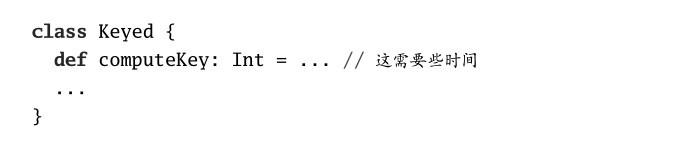  
假设computeKey既不读也不写任何var，可以通过添加缓存来让Keyed变得更高效：

In [8]:
class Keyed {
  def computeKey: Int = { // implementation for testing
    Thread.sleep(1000)
    123
  }
}

defined class Keyed

假设computeKey既不读也不写任何var，可以通过添加缓存来让Keyed变得更高效：

In [9]:
class MemoKeyed extends Keyed {
    private var keyCache: Option[Int] = None
    override def computeKey: Int = {
        if(!keyCache.isDefined) keyCache = Some(super.computeKey)
        keyCache.get
    }
}

defined class MemoKeyed

使用MemoKeyed而不是Keyed可以提速，因为computeKey操作第二次被请求时，可以直接返回保存在keyCache字段中的值，而不是再次运行computeKey。不过除了速度上的提升，Keyed类和MemoKeyed类的行为完全一致。因此，如果说Keyed是纯函数式的，那么 MemoKeyed同样也是，尽管它有一个可被重新赋值的变量。

In [10]:
val memoKeyed = new MemoKeyed
val keyed = new Keyed

println("start...");
println("keyed.computeKey [" + (keyed.computeKey) + "]")
println("memoKeyed.computeKey [" + (memoKeyed.computeKey) + "]")
println("memoKeyed.computeKey [" + (memoKeyed.computeKey) + "]")

start...
keyed.computeKey [123]
memoKeyed.computeKey [123]
memoKeyed.computeKey [123]


memoKeyed: MemoKeyed = ammonite.$sess.cmd8$Helper$MemoKeyed@32972798
keyed: Keyed = ammonite.$sess.cmd7$Helper$Keyed@1b5fd8b9

## 18.2 可被重新赋值的变量和属性

我们可以对一个可被重新赋值的变量做两种基本操作：获取它的值和将它设为新值。在诸如JavaBeans的类库中，这些操作通常被包装成单独的getter和setter方法，我们需要显式定义这些方法。

在Scala中，每一个非私有的v a r成员都隐式地定义了对应的getter和setter方法。不过，这些getter方法和setter方法的命名跟Java的习惯不一样。var x的getter方法只是命名为“x”，而它的setter方法命名为“x_=”。

举例来说，如果出现在类中，如下的var定义：

In [11]:
var hour =  12

hour: Int = 12

除了定义一个可被重新赋值的字段外，还将生成一个名为“hour”的getter和一个名为“hour_=”的setter。其中的字段总是被标记为 private[this]，意味着这个字段只能从包含它的对象中访问。而getter和setter则拥有跟原来的v a r相同的可见性。如果原先的v a r定义是公有的，那么它的getter和setter也是公有的；如果原先的v a r定义是p r o t e c t e d，那么它的getter和setter也是protected；以此类推。

举例来说，参考示例18.2中的Time类，它定义了两个公有的var,hour和minute：

In [12]:
class Time {
    var hour = 12
    var minute = 0
}

val time = new Time
println("time.hour [" + (time.hour) + "]")
println("time.minute [" + (time.minute) + "]")

time.hour = 13
time.minute = 14
println("time.hour [" + (time.hour) + "]")
println("time.minute [" + (time.minute) + "]")

time.hour [12]
time.minute [0]
time.hour [13]
time.minute [14]


defined class Time
time: Time = ammonite.$sess.cmd11$Helper$Time@594af2a9

<center>示例18.2 带有公有var的类</center>

这个实现跟示例18.3中的类定义完全等效。在示例18.3的定义中，局部字段h和m的名称是随意选的，只要不跟已经用到的名称冲突即可。

In [13]:
class Time {
    private[this] var h = 12 //private[this]意味着这个字段只能从包含它的对象中访问
    private[this] var m = 0  
    
    def hour: Int = h
    def hour_=(x: Int) = {h = x}
    
    def minute: Int = m
    def minute_=(x: Int) = {m = x}    
}


val time = new Time
println("time.hour [" + (time.hour) + "]")
println("time.minute [" + (time.minute) + "]")

time.hour = 13
time.minute = 14
println("time.hour [" + (time.hour) + "]")
println("time.minute [" + (time.minute) + "]")

time.hour [12]
time.minute [0]
time.hour [13]
time.minute [14]


defined class Time
time: Time = ammonite.$sess.cmd12$Helper$Time@530c0600

<center>示例18.3 公有var是如何被展开成getter和setter方法的</center>

这个将var展开成getter和setter的机制有趣的一点在于我们仍然可以直接定义getter和setter，而不是定义一个var。通过直接定义这些访问方法，可以按照自己的意愿来解释变量访问和赋值的操作。例如，示例18.4中的Time类变种包含了针对hour和minute赋值的要求，那些值是不合法的。

In [14]:
class Time {
    private[this] var h = 12 //private[this]意味着这个字段只能从包含它的对象中访问
    private[this] var m = 0
    
    def hour: Int = h
    def hour_=(x: Int) = {
        require(0 <= x && x < 24)
        h = x
    }
    
    def minute: Int = m
    def minute_=(x: Int) = {
        require(0 <= x && x < 60)
        m = x
    }    
}

val time = new Time
println("time.hour [" + (time.hour) + "]")
println("time.minute [" + (time.minute) + "]")

time.hour = 13
time.minute = 14
println("time.hour [" + (time.hour) + "]")
println("time.minute [" + (time.minute) + "]")

try {
  time.minute = 75
} catch {
  case ex: IllegalArgumentException => println("caught exception")
}

time.hour [12]
time.minute [0]
time.hour [13]
time.minute [14]
caught exception


defined class Time
time: Time = ammonite.$sess.cmd13$Helper$Time@6c913352

<center>示例18.4 直接定义getter和setter方法</center>

某些语言对于这些类似变量的值有特殊的语法表示，它们不同于普通变量的地方在于getter和setter可以被重新定义。例如C#有属性来承担这个角色。从效果上讲，Scala总是将变量解读为setter和getter方法的这个做法，让我们在不需要特殊语法的情况下获得了跟C#属性一样的能力。

属性可以有很多用途。在示例18.4中，setter强调了一个恒定的规则，防止变量被赋予非法值。我们还可以用属性来记录所有对变量getter和 setter的访问。或者将变量和事件集成起来，比如当变量被修改时都去通知那些订阅了该事件的订阅者方法（参考第35章的例子）。

有时候，定义不跟任何字段关联的getter和setter也是有用的，Scala允许我们这样做。举例来说，示例18.5给出了一个Thermometer类，这个类封装了一个表示温度的变量，可以被读取和更新。温度可以用摄氏和华氏来表示。这个类允许我们用任意一种标度来获取和设置温度。

In [15]:
class Thermometer {
    var celsius: Float = _
    def fahrenheit = celsius * 9 / 5 + 32
    def fahrenheit_= (f: Float) = {
        celsius = (f - 32) * 5 / 9
    }
    override def toString = fahrenheit + "F/" + celsius + "C"
}

defined class Thermometer

<center>示例18.5 定义没有关联字段的getter和setter方法</center>

这个类定义体的第一行定义了一个var变量celsius，用来包含摄氏度的温度。celsius变量一开始被设成缺省值，因为我们给出了“\_”作为它的 “初始值”。**更确切地说，某个字段的“= \_”初始化代码会给这个字段赋一个零值（zero value）**。具体零值是什么取决于字段的类型。数值类型的零值是0，布尔值的零值是false，引用类型的零值是null。这跟Java中没有初始化代 码的变量效果一样。
注意在Scala中并不能简单地去掉“= \_”。如果是这样写的：  
`var celsius: Float`  
这将会定义一个抽象变量，而不是一个没有被初始化的变量。[1]

在celsius变量之后，是getter方法“fahrenheit”和setter方法“fahrenheit_=”的定义，它们访问的是同一个温度变量，但是以华氏表示。并没有单独的变量来以华氏度保存温度。华氏度的getter和setter方法会自动与摄氏度做必要的转换。参考下面使用Thermometer对象的例子：

In [16]:
val t = new Thermometer

t.celsius = 100
println("t [" + (t) + "]")

t.fahrenheit = -40
println("t [" + (t) + "]")

t [212.0F/100.0C]
t [-40.0F/-40.0C]


t: Thermometer = -40.0F/-40.0C

## 18.3 案例分析：离散事件模拟
本章剩余部分将通过一个扩展的例子来展示可变对象跟一等函数值结合起来会产生怎样的效果。你将会看到一个数字电路模拟器的设计和实现。这个任务会被分解成若干个小问题，每个小问题单独拿出来看都非常有趣。

首先，你将看到一个用于描述数字电路的小型语言。该语言的定义将向我们展示在像Scala这样的宿主语言中嵌入领域特定语言（DSL）的一般方法。其次，我 们将展示一个简单但通用的用于离散事件模拟的框架。这个框架的主要任务是跟踪那些按模拟时间执行的动作。最后，我们将展示如何组织和构建离散模拟程序。这些模拟背后的理念是用模拟对象对物理对象建模，并利用这个模拟框架对物理时间建模。

这个例子取自Ableson和Sussman的经典教科书《Structure and Interpretation of Computer Programs》[Abe96]。不同的地方在于，我们的实现语言是Scala而不是Scheme，另外我们将例子的不同方面组织成四个层次：一个模拟框架，一个基本的线路模拟包，一个用户定义线路的类库，以及每个模拟线路本身。每一层都实现为一个类，更具体的层继承自更一般的层。

快速通道

理解本章的离散事件模拟的例子需要花些时间。如果你想继续了解更多关于Scala的内容，可以安全地跳到下一章。

## 18.4 用于描述数字电路的语言
我们从描述数字电路的“小型语言”开始。数字电路由线（wire）和功能箱（function box）组成。线负责传递信号（signal），而功能箱对信号进行转换。信号以布尔值表示：true代表信号开启，false代表信号关闭。  
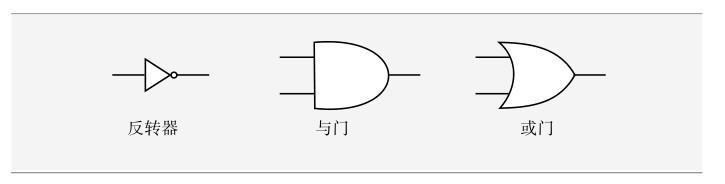  
<center>图18.1 基本的门</center>

图18.1展示了三种基本的功能箱，又称作门（gate）：  
● 反转器（inverter），对信号取反。  
● 与门（and-gate），将输出设为输入的逻辑与（conjunction）。  
● 或门（or-gate），将输出设为输入的逻辑或（disjunction）。

In [17]:
abstract class Simulation {

  type Action = () => Unit

  case class WorkItem(time: Int, action: Action)

  private var curtime = 0
  def currentTime: Int = curtime

  private var agenda: List[WorkItem] = List()

  private def insert(ag: List[WorkItem],
      item: WorkItem): List[WorkItem] = {

    if (ag.isEmpty || item.time < ag.head.time) item :: ag
    else ag.head :: insert(ag.tail, item)
  }

  def afterDelay(delay: Int)(block: => Unit) = {
    val item = WorkItem(currentTime + delay, () => block)
    agenda = insert(agenda, item)
  }

  private def next() = {
    (agenda: @unchecked) match {
      case item :: rest => 
        agenda = rest 
        curtime = item.time
        item.action()
    }
  }

  def run() = {
    afterDelay(0) {
      println("*** simulation started, time = " +
          currentTime + " ***")
    }
    while (!agenda.isEmpty) next()
  }
}


// abstract class CircuitSimulation
//   extends BasicCircuitSimulation {

//   def halfAdder(a: Wire, b: Wire, s: Wire, c: Wire) = {
//     val d, e = new Wire
//     orGate(a, b, d)
//     andGate(a, b, c)
//     inverter(c, e)
//     andGate(d, e, s)
//   }

//   def fullAdder(a: Wire, b: Wire, cin: Wire,
//       sum: Wire, cout: Wire) = {

//     val s, c1, c2 = new Wire
//     halfAdder(a, cin, s, c1)
//     halfAdder(b, s, sum, c2)
//     orGate(c1, c2, cout)
//   }
// }

//  object MySimulation extends CircuitSimulation {
//            def InverterDelay = 1
//            def AndGateDelay = 3
//            def OrGateDelay = 5

//   def main(args: Array[String]) {
//     val input1, input2, sum, carry = new Wire

//     probe("sum", sum)
//     probe("carry", carry)
//     halfAdder(input1, input2, sum, carry)

//     input1 setSignal true
//     run()

//     input2 setSignal true
//     run()
//   }
// }

defined class Simulation

这些门已经足以用于构建所有其他功能箱。门有延迟（delay），因此门的输出会在其输入变化之后过一段时间才改变。

我们将用下列Scala类和函数来描述数字电路的元素。首先，我们有一个Wrie类来表示线。可以像这样构建线：

In [18]:
abstract class BasicCircuitSimulation extends Simulation {

  def InverterDelay: Int
  def AndGateDelay: Int
  def OrGateDelay: Int

  class Wire {

    private var sigVal = false
    private var actions: List[Action] = List()

    def getSignal = sigVal

    def setSignal(s: Boolean) = 
      if (s != sigVal) {
        sigVal = s
        actions foreach (_ ()) 
      }

    def addAction(a: Action) = {
      actions = a :: actions
      a()
    }
  }

  def inverter(input: Wire, output: Wire) = {
    def invertAction() = {
      val inputSig = input.getSignal
      afterDelay(InverterDelay) {
        output setSignal !inputSig 
      }
    }
    input addAction invertAction
  }

  // continued in Listing 18.10...
  // ...continued from Listing 18.9
  def andGate(a1: Wire, a2: Wire, output: Wire) = {
    def andAction() = {
      val a1Sig = a1.getSignal
      val a2Sig = a2.getSignal
      afterDelay(AndGateDelay) {
        output setSignal (a1Sig & a2Sig) 
      }
    }
    a1 addAction andAction
    a2 addAction andAction
  }

  def orGate(o1: Wire, o2: Wire, output: Wire) = {
    def orAction() = {
      val o1Sig = o1.getSignal
      val o2Sig = o2.getSignal
      afterDelay(OrGateDelay) {
        output setSignal (o1Sig | o2Sig)
      }
    }
    o1 addAction orAction
    o2 addAction orAction
  }

  def probe(name: String, wire: Wire) = {
    def probeAction() = {
      println(name + " " + currentTime +
          " new-value = " + wire.getSignal)
    }
    wire addAction probeAction
  }
}

defined class BasicCircuitSimulation

考虑到Scala对于函数式的强调，有个不太寻常的地方是这些过程是以副作用的形式构建门的。举例来说，调用inverter（a, b）会在a和b两条线之间放置一个反转器。我们会发现这种通过副作用进行构建的方式让我们比较容易逐步构建出复杂的电路。除此之外，尽管方法通常都以动词 命名，这里的方法命名用的是名词，表示它们构建出来的门。这体现出的是DSL的声明性：它应该描述电路本身，而不是制作线路的行为。

通过这些基本的门，可以构建出更复杂的功能箱。比如示例18.6中构建的半加器。halfAdder方法接收两个输入信号a和b，产出一个由“s = （a + b） % 2”的和（sum）s，以及一个由“c = （a + b）/ 2”定义的进位信号（carry） c。半加器电路如图18.2所示。

注意，跟那三个构建基本门的方法一样，halfAdder也是一个参数化的功能箱。我们可以用halfAdder方法来构建更复杂的电路。例如，示例 18.7定义了一个一字节的全加器，如图18.3所示，接收两个输入信号a和b，以及一个低位进位cin，产出一个由“sum = （a + b + cin） % 2”定义的输出和，以及一个由“cout = （a + b + cin）/ 2”定义的高位进位输出信号。

In [19]:
abstract class CircuitSimulation_Test
  extends BasicCircuitSimulation {

  def halfAdder(a: Wire, b: Wire, s: Wire, c: Wire) = {
    val d, e = new Wire
    orGate(a, b, d)
    andGate(a, b, c)
    inverter(c, e)
    andGate(d, e, s)
  }

  def fullAdder(a: Wire, b: Wire, cin: Wire,
      sum: Wire, cout: Wire) = {

    val s, c1, c2 = new Wire
    halfAdder(a, cin, s, c1)
    halfAdder(b, s, sum, c2)
    orGate(c1, c2, cout)
  }
}

defined class CircuitSimulation_Test

<center>示例18.6 halfAdder方法</center>

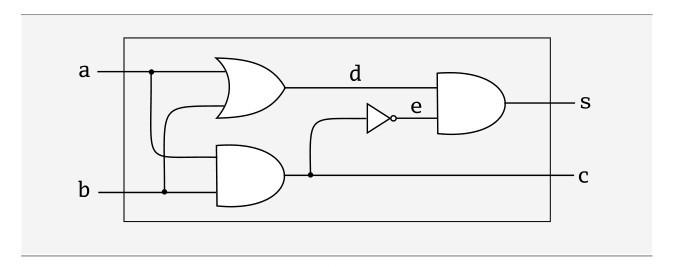  
<center>图18.2 半加器电路</center>  

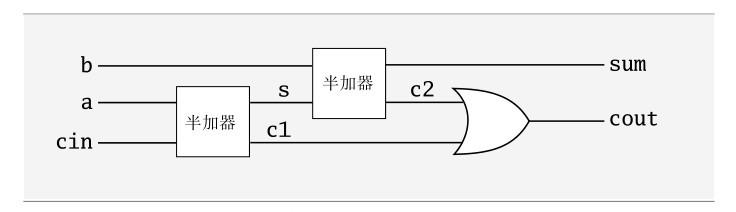  
<center>图18.3 全加器电路</center>


Wire类和inverter、andGate、orGate函数构成了用户用来定义数字电路的小型语言。这是内部（internal）DSL的绝佳示例，一个在宿主语言中以类库形式定义（而非独立实现）的领域特定语言。

我们的电路DSL实现仍需要打磨。由于用DSL定义电路的目的是模拟这个电路，我们有理由将这个DSL基于一个通用的离散时间模拟来实现。接下来的两节，我们首先介绍模拟API，然后在此基础上介绍电路DSL的实现。

## 18.5 Simulation API
模拟API如示例18.8所示。它包含了org.stairwaybook.simlulation包的Simulation类。具体的模拟类库继承自这个类，并补充扩展领域特定的功能。本节将介绍Simulation类的元素。
离散事件模拟在指定的时间（time）执行用户定义的动作（action）。所有有具体模拟子类定义的动作都是如下类型的：

In [20]:
abstract class Simulation {
//=============================================================
// 这条语句将Action定义为接收空参数列表并返回Unit的过程类型的别名。
// Action是Simulation类的类型成员（type member）。
// 可以将它想象成（）=> Unit这个类型更可读的名字。
// 关于类型成员的更详细内容请参考20.6节。 
  type Action = () => Unit

//=============================================================
// 一个需要在指定时间执行的动作被称为工作项（work item）。工作项由如下这个类实现：
  case class WorkItem(time: Int, action: Action)
// 我们将WorkItem处理成样例类，这是由于样例类的便捷性：
// 可以用WorkItem工厂方法创建该类的示例，
// 还可以免费获得对构造方法参数time和action的getter方法。
// 还要注意一点，WorkItem类是内嵌在Simulation类里的。
// Scala对嵌套类的处理跟Java类似。更多细节请参考20.7节。

//=============================================================
// 动作被执行的时间是模拟时间，跟实际的“挂钟”（wall clock）时间无关。
// 模拟时间简单地以整数表示，当前的模拟时间保存在私有变量里：
  private var curtime = 0
// 这个变量有一个公有的访问方法，用于获取当前时间：
  def currentTime: Int = curtime
// 这样的私有变量和公有访问方法的组合用来确保当前时间不会被Simulation类外部修改。
// 毕竟，你并不想让你的模拟对象来操纵当前时间，除非你的模拟场景要考虑时间旅行。

    
//=============================================================
// Simulation类有一个日程（agenda），记录了所有还未执行的工作项。
// 工作项的排序依据是它们需要执行的模拟时间：
  private var agenda: List[WorkItem] = List()

// 列表agenda的排序由更新它的insert方法保证。
// 我们可以看到insert方法的调用来自afterDelay，这也是向日程添加工作项的唯一方式：
  private def insert(ag: List[WorkItem],
      item: WorkItem): List[WorkItem] = {
      
// 被创建出来的工作项还需要被插入到日程中。
// 可以通过insert方法来完成，这个方法保证了日程是按时间排序的：
    if (ag.isEmpty || item.time < ag.head.time) item :: ag
    else ag.head :: insert(ag.tail, item)
  }

// 正如这个名称表达的，这个方法向日程中插入一个动作（由block给出），
// 计划在当前模拟时间之后的若干（由delay给出）时间单元执行。
// 举例来说，如下调用会创建一个新的工作项，在模拟时间currentTime + delay执行：
// afterDelay(delay) { count += 1}
  def afterDelay(delay: Int)(block: => Unit) = {
    val item = WorkItem(currentTime + delay, () => block)
    agenda = insert(agenda, item)
  }
// 要执行的代码包含在方法的第二个入参。
// 这个入参的形参类型为“=>Unit”（即按名传递的类型为Unit的计算）。
// 我们可以回忆一下，传名参数在传入方法时并不会被求值。
// 因此在上面的调用中，count只会在模拟框架调用存放在工作项当中的动作时被加1。
// 注意afterDelay是一个柯里化的函数。
// 这是在9.5节定下的关于柯里化能帮我们把方法调用做成像内建语法这个原则的一个很好的例子。

//=============================================================
// next方法用模式匹配将当前的日程拆成一个最开始的工作项item和剩下的工作项rest两部分。
// 然后将最开始的工作项item从当前日程移除，将模拟时间curtime设置为工作项的时间，
// 并执行该工作项的动作。
// 注意next只能在日程不为空时调用。我们并没有给出空列表的case，
// 因此当我们尝试对空日程运行next时，将得到一个MatchError异常。
// 事实上，Scala编译器通常会警告我们漏掉了列表的某个可能的模式。
// 在本例中，缺失的这个case并不是问题，因为我们知道next只在非空的日程才会被调用。
// 因此，我们可能会想要禁用这个警告。
// 在15.5节提到过，可以通 过对模式匹配的选择器表达式添加 @unchecked 注解来禁用警告。
// 这也是为什么Simulation代码使用“（agenda: @unchecked）match
// ”而不是“agenda match”。    
  private def next() = {
    (agenda: @unchecked) match {
      case item :: rest => 
        agenda = rest 
        curtime = item.time
        item.action()
    }
  }

// Simulation类的核心是下面这个run方法：
// run方法不断重复地从日程中获取第一个工作项，
// 从日程移除并执行，直到日程中没有更多要执行的工作项为止。
// 每一步都会调用next方法，定义如下：
  def run() = {
    afterDelay(0) {
      println("*** simulation started, time = " +
          currentTime + " ***")
    }
    while (!agenda.isEmpty) next()
  }
}

defined class Simulation

就是这样了。对于模拟框架而言，这可能看上去代码相当少。你可能会好奇这样简单的框架怎么可能支持有意义的模拟，它不过是简单地执行工作项列表而已嘛。事实 上，这个模拟框架的威力来自这样一个事实：存储在工作项列表中的动作可以在被执行时自己向日程中登记后续的工作项。这让我们可以从简单的开头演化出长时间 的模拟。

## 18.6 电路模拟
接下来，我们将用这个模拟框架来实现18.4节展示的电路DSL。我们回顾一下，电路DSL由表示线的类和创建与门、或门和反转器的方法构成。所有这些都包 含在BasicCircuitSimulation类中，这个类继承自模拟框架。

BasicCircuitSiumulation 类声明了三个抽象方法来表示基本门的延迟：InverterDelay、AndGateDelay和OrGateDelay。实际的延迟在这个类的层次是未知的，因为它们取决于被模拟电路采用的技术。这就是为什么在BasicCircuitSimulation类中这些延迟是抽象的，这样它们的具体定义就代理给了子类来完成。[2]接下来我们将介绍BasicCircuitSimulation类的其他成员。

### Wire类

线需要支持三种基本动作：  
getSignal: Boolean：返回线的当前信号。  
setSignal（sig: Boolean）：将线的信号设置为sig。  
addAction（p: Action）：将给定的过程p附加在线的actions中。所有附加在线上的动作过程会在每次线的信号发生变化时被执行。通常线上的动作都是由连接到线上的组件添加的。附加的动作会在添加到线上的时候执行一次，然后当线的信号发生变化时，都会再次执行。

以下是Wire类的实现：

In [21]:
abstract class BasicCircuitSimulation extends Simulation {

  def InverterDelay: Int
  def AndGateDelay: Int
  def OrGateDelay: Int

//======================================================================
// 线的状态由两个私有变量决定。
// sigVal变量表示当前的信号，而actions表示当前附加到线上的动作过程。
// 唯一有趣的方法实现是setSignal： 当线的信号发生变化时，新的值被存在变量sigVal中。
// 不止如此，所有附加到线上的动作都会被执行。
// 注意执行这个操作的简写语法：“actions foreach（_（））”，
// 这段代码会对actions列表中的每个元素应用函数“_ （）”。
// 正如我们在8.5节提到的，函数“_ （）”是“f => f（）”的简写，
// 它接收一个函数（被称为f）并将它应用到空的参数列表。
  class Wire {

    private var sigVal = false
    private var actions: List[Action] = List()

    def getSignal = sigVal

    def setSignal(s: Boolean) = 
      if (s != sigVal) {
        sigVal = s
        actions foreach (_ ()) 
      }

    def addAction(a: Action) = {
      actions = a :: actions
      a()
    }
  }

//======================================================================
// 创建反转器的唯一作用是将一个动作安装到输入线上。
// 这个动作在安装时执行一次，然后每次输入变化时都会再次执行。
// 这个动作的效果是设置反转器的输出值（通过 setSignal）为与输入相反的值。
// 由于反转器有延迟，这个变化只有在输入值变更后的InverterDelay的模拟时间过后才会被执行。
// 这让我们得到下面的实现：
  def inverter(input: Wire, output: Wire) = {
    def invertAction() = {
      val inputSig = input.getSignal
      afterDelay(InverterDelay) {
        output setSignal !inputSig 
      }
    }
    input addAction invertAction
  }
// inverter 方法的作用是将invertAction添加到输入线。
// 这个动作在执行时会读取输入信号并安装另一个将输出信号反转的动作到模拟日程中。
// 后一个动作将在 InverterDelay的模拟时间后执行。
// 注意这个方法是如何利用模拟框架的afterDelay方法来创建一个新的在未来执行的工作项的。


//======================================================================
// 与门的实现跟反转器的实现类似。与门的目的是输出其输入信号的逻辑与结果。
// 这应该在两个输入中任何一个发生变化后的AndGateDelay模拟时间后发生。
// 因此我们得到如下实现：
  def andGate(a1: Wire, a2: Wire, output: Wire) = {
    def andAction() = {
      val a1Sig = a1.getSignal
      val a2Sig = a2.getSignal
      afterDelay(AndGateDelay) {
        output setSignal (a1Sig & a2Sig) 
      }
    }
    a1 addAction andAction
    a2 addAction andAction
  }
// andGate 方法的作用是添加一个andAction到两个输入线a1和a2。
// 当这个动作被调用时，同时获取两个输入信号并安装另一个动作，
// 将output信号设置为输入信号的逻辑与。
// 后一个动作将在AndGateDelay所指定的模拟时间后执行。
// 注意当任意一根输入线的信号变化时，输出都需要被重新计算。
// 这就是为什么同一个andAction会被同时安装到输入线a1和a2。
// orGate的实现也类似，不过它执行的是逻辑或，而不是逻辑与运算。
  def orGate(o1: Wire, o2: Wire, output: Wire) = {
    def orAction() = {
      val o1Sig = o1.getSignal
      val o2Sig = o2.getSignal
      afterDelay(OrGateDelay) {
        output setSignal (o1Sig | o2Sig)
      }
    }
    o1 addAction orAction
    o2 addAction orAction
  }

//======================================================================
// 为了运行这个模拟器，我们需要一种方式来观察线上信号的变化。
// 要做到这一点，可以通过给线添加探测器来模拟这个动作：
  def probe(name: String, wire: Wire) = {
    def probeAction() = {
      println(name + " " + currentTime +
          " new-value = " + wire.getSignal)
    }
    wire addAction probeAction
  }
}
// probe过程的作用是安装一个probeAction到给定的线上。
// 跟平常一样，这个安装的动作在每次线的信号发生变化时被执行。
// 在本例中它仅仅是打印出线的名称（作为probe的首个参数传入），
// 以及当前的模拟时间和线的新值。

defined class BasicCircuitSimulation

### 运行模拟器
在所有这些准备工作过后，我们终于可以运行这个模拟器了。为了定义一个具体的模拟场景，我们需要从模拟框架类做一次继承。我们将创建一个抽象的模拟类，这个类扩展自BasicCircuitSimulation，包含了半加器和全加器的方法定义（参考示例18.6和18.7）。这个类（被称为 CircuitSimulation）的完整定义如示例18.11所示。

In [22]:
abstract class CircuitSimulation
  extends BasicCircuitSimulation {

  def halfAdder(a: Wire, b: Wire, s: Wire, c: Wire) = {
    val d, e = new Wire
    orGate(a, b, d)
    andGate(a, b, c)
    inverter(c, e)
    andGate(d, e, s)
  }

  def fullAdder(a: Wire, b: Wire, cin: Wire,
      sum: Wire, cout: Wire) = {

    val s, c1, c2 = new Wire
    halfAdder(a, cin, s, c1)
    halfAdder(b, s, sum, c2)
    orGate(c1, c2, cout)
  }
}

defined class CircuitSimulation

<center>示例18.11 CircuitSimulation类</center>

具体的电路模拟将会是一个继承自CircuitSimulation类的对象。这个对象仍需要根据其模拟的电路实现技术来固定门的延迟。最后，我们还需要定义出具体的要摸拟的电路。
可以在Scala解释器中交互式地执行这些步骤：  
首先是门的延迟。定义一个对象（MySimulation），提供一些数字：

In [23]:
object MySimulation extends CircuitSimulation {
           def InverterDelay = 1
           def AndGateDelay = 3
           def OrGateDelay = 5
}

defined object MySimulation

由于我们将反复访问MySimulation对象的这些成员，做一次对象引入将让后续的代码变得更短：

In [24]:
import MySimulation._
val input1, input2, sum, carry = new Wire

import MySimulation._

input1: Wire = ammonite.$sess.cmd20$Helper$BasicCircuitSimulation$Wire@56c3aec1
input2: Wire = ammonite.$sess.cmd20$Helper$BasicCircuitSimulation$Wire@40413ecc
sum: Wire = ammonite.$sess.cmd20$Helper$BasicCircuitSimulation$Wire@4ebfa876
carry: Wire = ammonite.$sess.cmd20$Helper$BasicCircuitSimulation$Wire@3117f6d

In [25]:
probe("sum", sum)

sum 0 new-value = false


In [26]:
probe("carry", carry)

carry 0 new-value = false


注意这些探测器会立即打印出结果。这时因为每当动作被安装到线上都会执行一次。  
现在定义一个连接这些线的半加器：

In [27]:
halfAdder(input1, input2, sum, carry)

最后，先后将两根输入线设置信号设置为true并运行模拟：

In [28]:
input1 setSignal true

In [29]:
run()

*** simulation started, time = 0 ***
sum 8 new-value = true


In [30]:
input2 setSignal true

In [31]:
run()

*** simulation started, time = 8 ***
carry 11 new-value = true
sum 15 new-value = false


## 18.7 结语
本章将两种乍看上去毫不相干的技巧结合到了一起：可变状态和高阶函数。可变状态用于模拟那些状态随时间改变的物理实体。而高阶函数在模拟框架中用来在指定的模拟时间执行动作。高阶函数还在电路模拟中被当作触发器（trigger）使用，它们跟状态变化关联起来。在这个过程中，还看到了一种简单的方式来定义以类库的形式定义领域特定语言。这些内容对于一章的篇幅而言可能足够了吧！

如果你还意犹未尽，可以尝试更多模拟例子。比如可以用半加器和全加器创建更大型的电路，或者用目前已有的基本的门来定义新的电路并进行模拟。在下一章，你将了解到Scala的类型参数化，同时还会看到另一个将函数式和指令式结合起来交出好的解决方案的例子。

[1].第20章将会有抽象变量的详细介绍。  
[2].这些“延迟”（delay）方法的名称以大写字母开头，因为它们表示的是一些常量。它们被定义成方法，因此可以被子类重写。你将在20.3节了解如何对val做同样的事。